In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

exp_inc_dosage = {0: 0.01, 1:0.026, 2:0.068, 3: 0.176, 4: 0.457, 5: 1.188, 6:3.089, 21: 5}
exp_dec_dosage = {0: 3.089, 1: 1.188, 2: 0.457, 3:0.176, 4:0.068, 5:0.026, 6:0.01, 21:5}
constant_dosage = {0: 0.714, 1: 0.714, 2: 0.714, 3: 0.714, 4: 0.714, 5: 0.714, 6: 0.714, 21: 5}
bolus21_dosage = {0: 5, 21: 5}
bolus28_dosage = {0: 5, 28: 5}
exp_inc_2wk_dosage = {0: 0.01, 2:0.026, 4:0.068, 6: 0.176, 8: 0.457, 10: 1.188, 12:3.089, 28: 5}
bolus_prime_exp_inc_boost_dosage = {0: 5, 28: 0.01, 30:0.026, 32:0.068, 34: 0.176, 36: 0.457, 38: 1.188, 40:3.089,}
exp_inc_prime_and_boost_dosage = {0: 0.01, 2:0.026, 4:0.068, 6: 0.176, 8: 0.457, 10: 1.188, 12:3.089, 28: 0.01, 30:0.026, 32:0.068, 34: 0.176, 36: 0.457, 38: 1.188, 40:3.089,}

def convert_to_tensor(dosage):
    arr = []
    for i in range(0, 41):
        arr.append(float(dosage.get(i, 0)))
    return torch.tensor(arr)

dosage_dict = {"Exp-inc": convert_to_tensor(exp_inc_dosage), "Exp-dec":convert_to_tensor(exp_dec_dosage), 
            "Constant": convert_to_tensor(constant_dosage), "Bolus": convert_to_tensor(bolus21_dosage), 
            "Boost d28": convert_to_tensor(bolus28_dosage), "Exp Increase 2wk": convert_to_tensor(exp_inc_2wk_dosage), 
            "Exp Boost": convert_to_tensor(bolus_prime_exp_inc_boost_dosage), "Exp Prime/Boost": convert_to_tensor(exp_inc_prime_and_boost_dosage)}

class Data(torch.utils.data.Dataset):
    def __init__(self, dosages, results):
        self.dosages = dosages
        self.results = results
    def __len__(self):
        return len(self.results)
    def __getitem__(self, index):
        dosage = self.dosages[index]
        result = self.results[index]
        return dosage, result

data = pd.read_csv("2024-10-27 Tam 2016 Data.csv")
data = data.replace('-', np.nan)
data = data.replace("Exp Increase 1wk", "Exp-inc")
data["Binding"] = data["Binding"].astype("float32")
data["Time"] = data["Time"].transform(lambda x: int(x[3:]))
data = data.drop(data[data["Time"]>56].index)
data = data.reset_index(drop=True)
data["Subject"] = data["Subject"].transform(lambda x: int(x[6:]))

for i in range(len(data)):
    if math.isnan(data.iloc[i, data.columns.get_loc("Binding")]):
        time = int(data.iloc[i, data.columns.get_loc("Time")])
        dosing = str(data.iloc[i, data.columns.get_loc("Vaccine Scheme")])
        mean = data[(data["Time"]==time) & (data["Vaccine Scheme"]==dosing)]["Binding"].mean()
        data.loc[i, ["Binding"]] = mean

dosages = data.groupby("Subject")["Vaccine Scheme"].nth(0)
dosages = [dosage_dict[x] for x in dosages.to_list()]
results = data.groupby("Subject")["Binding"].apply(list)
results = [torch.tensor(x) for x in results.to_list()]

epoch 1, loss 15701.77578125
epoch 2, loss 15651.694989013671
epoch 3, loss 15568.733197021484
epoch 4, loss 15401.794134521484
epoch 5, loss 15048.739001464844
epoch 6, loss 14339.85327758789
epoch 7, loss 13107.383349609376
epoch 8, loss 11442.92349243164
epoch 9, loss 9796.938586425782
epoch 10, loss 8456.277493286132
epoch 11, loss 7373.877337646484
epoch 12, loss 6488.751538085938
epoch 13, loss 5784.601348876953
epoch 14, loss 5253.871875
epoch 15, loss 4879.764636230469
epoch 16, loss 4625.158560180664
epoch 17, loss 4435.515786743164
epoch 18, loss 4268.79487915039
epoch 19, loss 4129.759674072266
epoch 20, loss 3997.754473876953
epoch 21, loss 3842.5006103515625
epoch 22, loss 3708.0631317138673
epoch 23, loss 3587.5081329345703
epoch 24, loss 3476.445391845703
epoch 25, loss 3374.318957519531
epoch 26, loss 3284.3335388183596
epoch 27, loss 3207.386267089844
epoch 28, loss 3130.3707946777345
epoch 29, loss 3076.8038482666016
epoch 30, loss 3018.0347290039062
epoch 31, loss 29

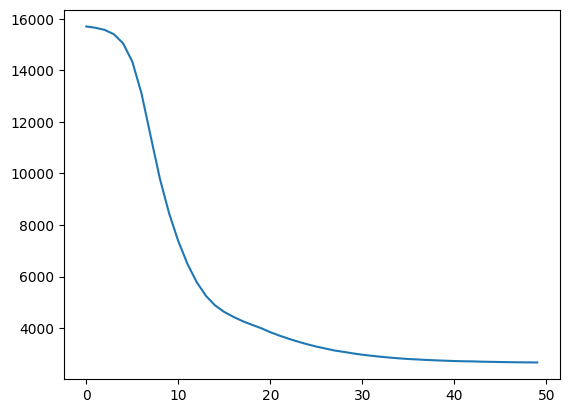

In [2]:
class RegressionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(torch.nn.LazyLinear(64), torch.nn.ReLU(), torch.nn.LazyLinear(8))

    def forward(self, x):
        return self.net(x)

def train(model, data, epochs, lr):
    lossFunction = torch.nn.MSELoss(reduction="mean")
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    prevLoss = float("inf")

    losses = []
    for i in range(1, epochs+1):
        epoch_loss = 0
        for batch in data:
            features, labels = batch
            optimizer.zero_grad()
            y_pred = model(features)
            
            loss = lossFunction(y_pred, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        losses.append(epoch_loss/len(data))
        print('epoch {}, loss {}'.format(i, epoch_loss/len(data)))

        if(epoch_loss>prevLoss):
            print("Stopped early on epoch {}".format(i))
            break
        prevLoss = epoch_loss
    
    plt.plot(range(len(losses)), losses)
    plt.show()
    

model = RegressionModel()

dataset = Data(dosages, results)
batch_size = 16
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

train(model=model, data=dataloader, epochs=50, lr=0.0005)

144.8298797607422


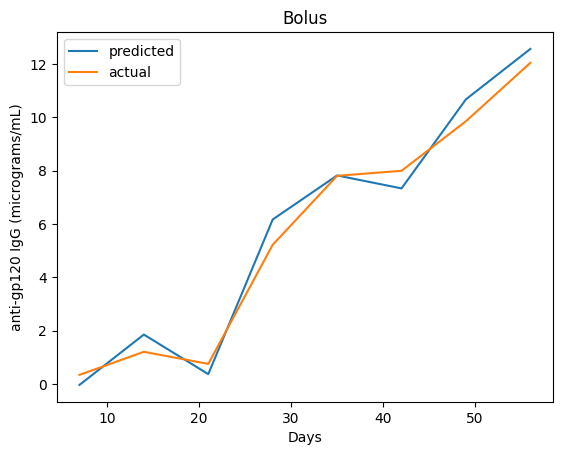

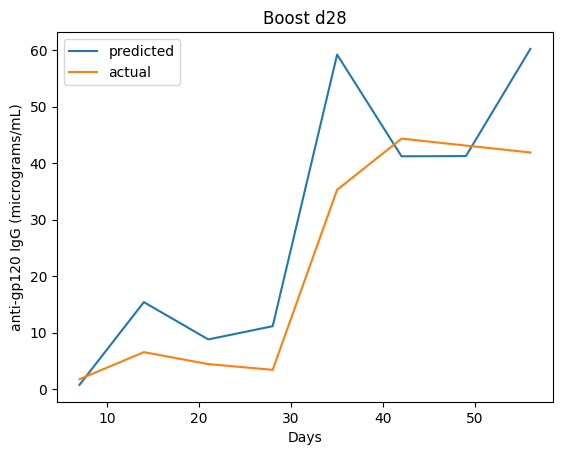

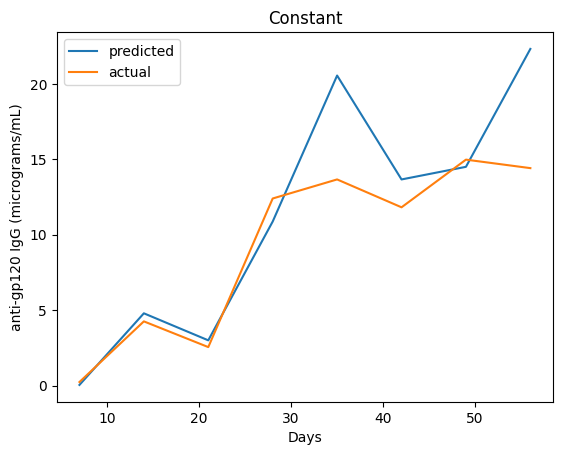

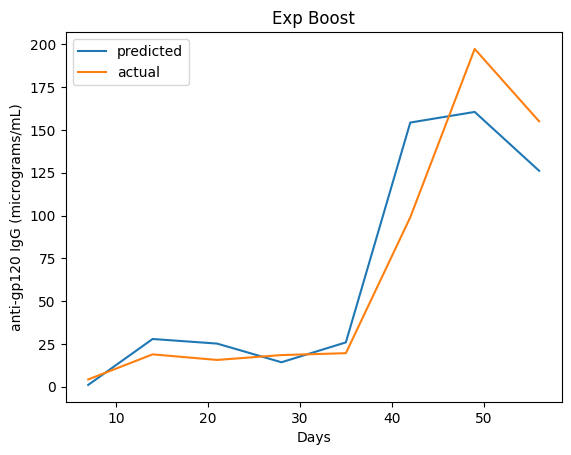

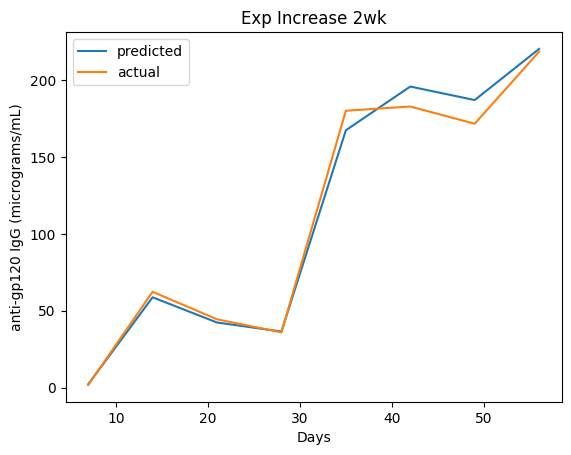

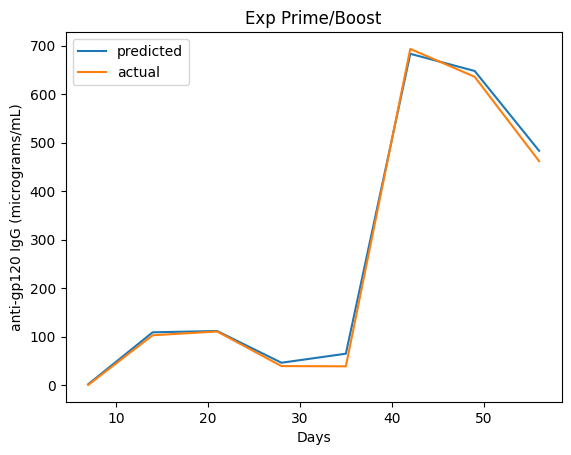

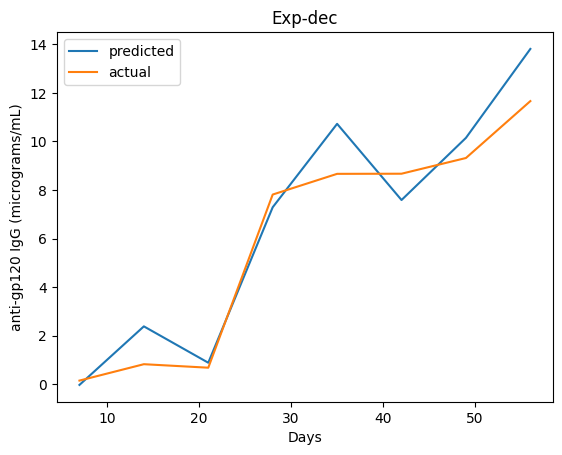

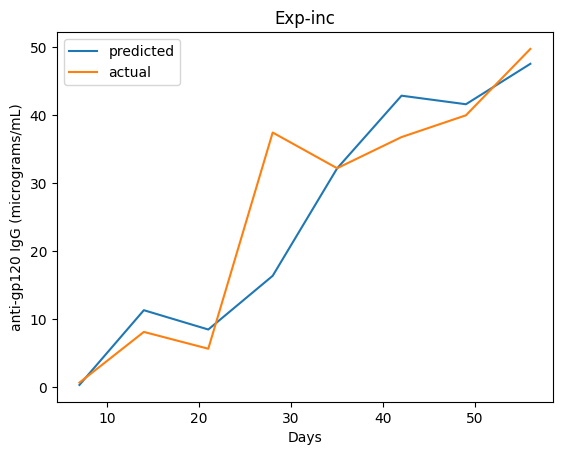

tensor([ 1.1162,  5.6222,  4.9672, 12.4899, 24.5496, 22.6137, 21.7806, 29.6379],
       grad_fn=<ViewBackward0>)
tensor([  0.9979,  34.9376,  32.4216,  17.6790,  43.0625, 189.0521, 181.9450,
        149.4216], grad_fn=<ViewBackward0>)
tensor([ 0.4759, 11.6994,  6.7989,  8.4865, 43.3397, 31.6294, 31.8696, 45.4392],
       grad_fn=<ViewBackward0>)
tensor([  0.8364,  29.5158,  17.8693,  21.8637, 118.5443,  72.0295,  66.2854,
        108.4731], grad_fn=<ViewBackward0>)


In [9]:
means = data.groupby(["Vaccine Scheme", "Time"])["Binding"].mean()
dosages = []
dosage_names = []
results = []
result = []
for index, value in means.items():
    if index[1]==7:
        dosages.append(dosage_dict[index[0]])
        dosage_names.append(index[0])
        results.append(torch.tensor(result))
        result = []
    result.append(value)
results.append(torch.tensor(result))
results = results[1:]
test_data = Data(dosages, results)

test_data = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)

features, labels = next(iter(test_data))
prediction = model(features)

lossFunction = torch.nn.MSELoss(reduction="mean")
loss = lossFunction(prediction, labels)
print(loss.item())
for i, pred in enumerate(prediction):
    plt.plot(range(7, 63, 7), pred.tolist(), label="predicted")
    plt.plot(range(7, 63, 7), labels[i].tolist(), label="actual")
    ax = plt.gca()
    plt.xlabel("Days")
    plt.ylabel("anti-gp120 IgG (micrograms/mL)")
    plt.title(dosage_names[i])   
    plt.legend()
    plt.show()

test_dosage1 = {0: 1.25, 1: 1.25, 2: 1.25, 3:25, 4:1.25, 5:1.25, 6:1.25, 21: 1.25}
test_dosage2 = {0: 0.714, 2:0.714, 4:0.714, 6: 0.714, 8: 0.714, 10: 0.714, 12:0.714, 28: 0.714, 30:0.714, 32:0.714, 34: 0.714, 36: 0.714, 38: 0.714, 40:0.714}
test_dosage3 = {0: 3.089, 2:1.188, 4:0.457, 6: 0.176, 8: 0.068, 10: 0.026, 12:0.01, 28: 3.089, 30:1.188, 32:0.457, 34: 0.176, 36: 0.068, 38: 0.026, 40:0.01}
test_dosage4 = {0: 2, 28: 8}

test_prediction = model(convert_to_tensor(test_dosage1))
test_prediction2 = model(convert_to_tensor(test_dosage2))
test_prediction3 = model(convert_to_tensor(test_dosage3))
test_prediction4 = model(convert_to_tensor(test_dosage4))
print(test_prediction)
print(test_prediction2)
print(test_prediction3)
print(test_prediction4)